# Chap 15 - Ex3: apply GMM to cluster data in Online_Retail.xlsx

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

np.set_printoptions(suppress = True)
pd.set_option('display.width', 1000)

In [2]:
retail = pd.read_excel('Data/Online_Retail.xlsx')
retail

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [3]:
retail.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## <span style = 'color:yellow'> Feature Engineering: calculate new columns {Sales_avg, Sales_count}

In [4]:
retail = (
    retail.dropna()
    .assign(Quantity = lambda df: np.abs(df['Quantity']))
    .assign(Sales = lambda df: df['Quantity'] * df['UnitPrice']) #Calculate Sales = Quantity*Unitprice
)

retail_groupby = (
    retail.groupby(['CustomerID', 'InvoiceNo']).agg({'Sales':'sum'})
    .reset_index()
)
retail_groupby

,CustomerID,InvoiceNo,Sales
0,12346.0,541431,77183.60
1,12346.0,C541433,77183.60
2,12347.0,537626,711.79
3,12347.0,542237,475.39
4,12347.0,549222,636.25
...,...,...,...
22185,18283.0,579673,223.61
22186,18283.0,580872,208.00
22187,18287.0,554065,765.28
22188,18287.0,570715,1001.32


In [5]:
retail_processed = (
    retail_groupby.groupby('CustomerID').agg({'Sales':'mean', 'InvoiceNo':'count'})
    .reset_index()
    .pipe(lambda df: df.set_axis(['CustomerID', 'Sales_avg', 'Sales_count'], axis = 1)) #Change columns' name
)
retail_processed

,CustomerID,Sales_avg,Sales_count
0,12346.0,77183.600000,2
1,12347.0,615.714286,7
2,12348.0,449.310000,4
3,12349.0,1757.550000,1
4,12350.0,334.400000,1
...,...,...,...
4367,18280.0,180.600000,1
4368,18281.0,80.820000,1
4369,18282.0,59.833333,3
4370,18283.0,130.930000,16


In [6]:
retail_processed.describe()

,CustomerID,Sales_avg,Sales_count
count,4372.000000,4372.000000,4372.000000
mean,15299.677722,383.887274,5.075480
std,1722.390705,2113.853652,9.338754
min,12346.000000,0.000000,1.000000
25%,13812.750000,161.240167,1.000000
50%,15300.500000,247.011667,3.000000
75%,16778.250000,381.143000,5.000000
max,18287.000000,112314.033333,248.000000


## <span style = 'color:yellow'> Check normal distribution and outliers of Sales_avg and Sales_count

Normality test of Sales_avg: ShapiroResult(statistic=0.04405423943971176, pvalue=3.1166328316963724e-91)
Normality test of Sales_count: ShapiroResult(statistic=0.37696582300089954, pvalue=1.1751929290219582e-81)



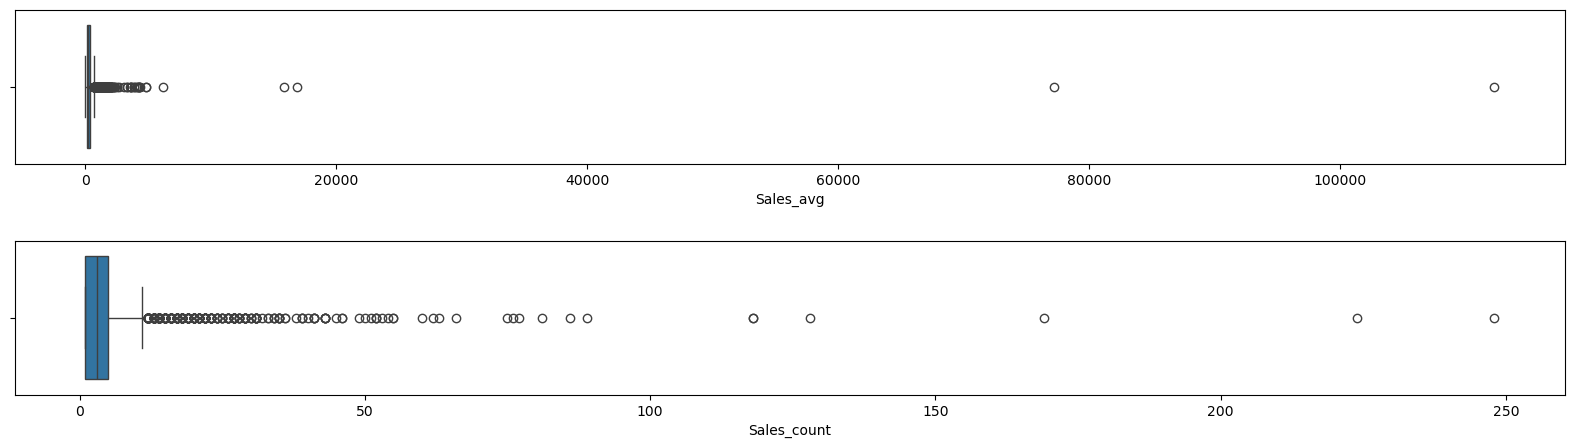


Sales_avg and Sales_count are not normally distributed, and also have outliers => LogScaler 



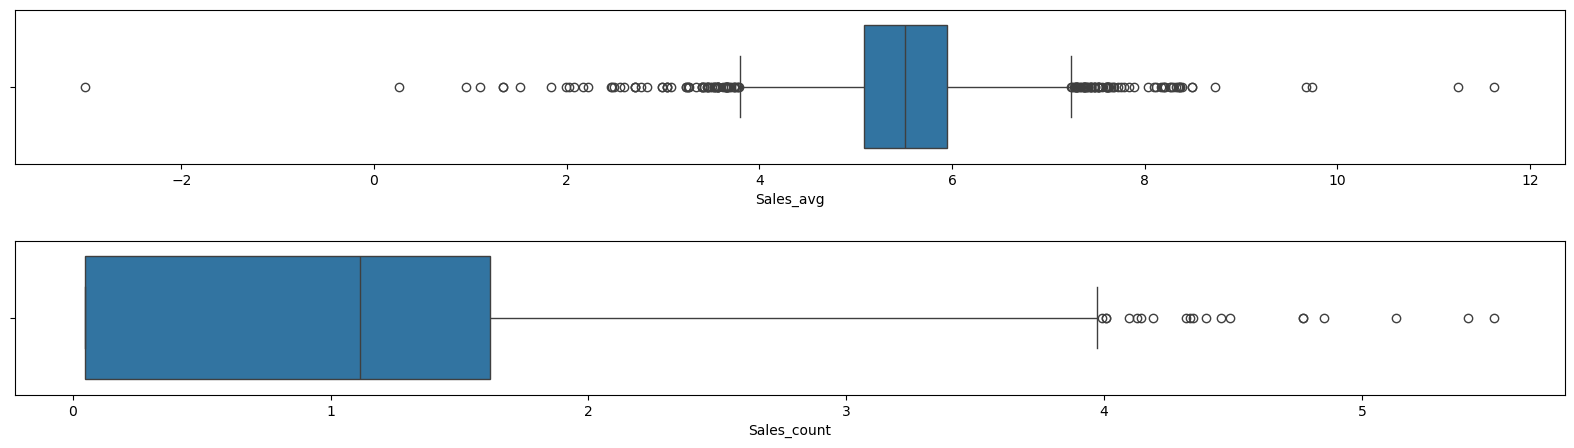

In [11]:
from scipy.stats import shapiro
print(f'Normality test of Sales_avg: {shapiro(retail_processed['Sales_avg'])}')
print(f'Normality test of Sales_count: {shapiro(retail_processed['Sales_count'])}')
print()

plt.figure(figsize = (20,5))
plt.subplot(2,1,1)
sbn.boxplot(data = retail_processed, x = 'Sales_avg')
plt.subplot(2,1,2)
sbn.boxplot(data = retail_processed, x = 'Sales_count')
plt.subplots_adjust(hspace=0.5)
plt.show()

print('\nSales_avg and Sales_count are not normally distributed, and also have outliers => LogScaler \n')

plt.figure(figsize = (20,5))
plt.subplot(2,1,1)
sbn.boxplot(data = retail_processed, x = np.log(retail_processed['Sales_avg'] + 0.05))
plt.subplot(2,1,2)
sbn.boxplot(data = retail_processed, x = np.log(retail_processed['Sales_count'] + 0.05))
plt.subplots_adjust(hspace=0.5)
plt.show()

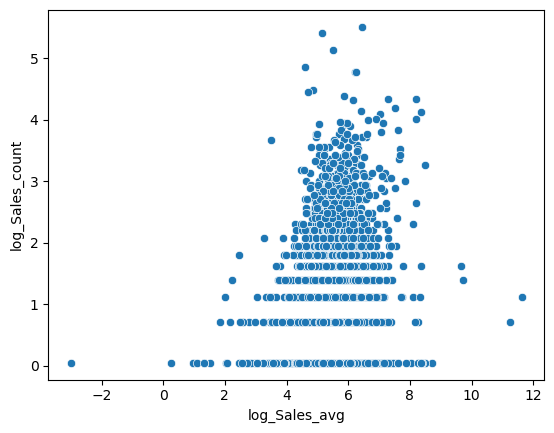

In [13]:
sbn.scatterplot(x = np.log(retail_processed['Sales_avg'] + 0.05), y = np.log(retail_processed['Sales_count'] + 0.05))
plt.xlabel('log_Sales_avg')
plt.ylabel('log_Sales_count')
plt.show()

## <span style = 'color:yellow'> Combine LogScaler with RobustScaler
## <span style = 'color:yellow'> Use Silhoutte Score to find optimal K clusters

/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


Silhouette score for k = 2: 0.4466198488282617


/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


Silhouette score for k = 3: 0.4872285607229955


/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


Silhouette score for k = 4: 0.4537027077647484


/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


Silhouette score for k = 5: 0.43953708482012793


/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


Silhouette score for k = 6: 0.43029079408751614


/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


Silhouette score for k = 7: 0.41726649910986485


/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


Silhouette score for k = 8: 0.4261003143381


/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


Silhouette score for k = 9: 0.42616083658470627


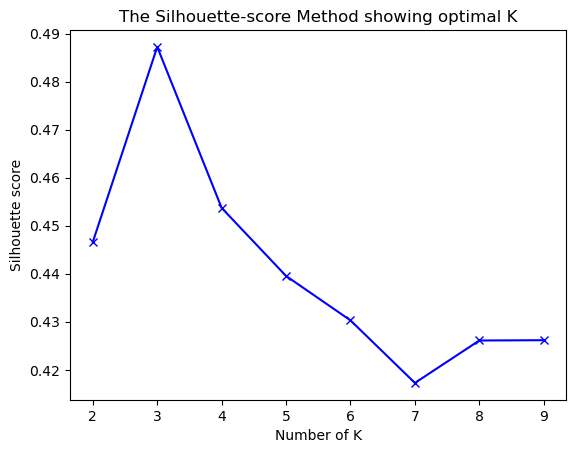

In [36]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.compose import make_column_transformer
import math

LogScaler = FunctionTransformer(func = lambda x: np.log(x + 0.05), 
                                inverse_func = lambda x: (np.exp(x) - 0.05), 
                                validate = True)

silh_score = []
k_nums = range(2,10)

data = retail_processed.drop('CustomerID', axis = 1)

for k in k_nums:
    gmm_pipe = Pipeline([
        ('LogScaler', make_column_transformer((LogScaler, data.columns), remainder='passthrough')),
        ('MinMaxScaler', MinMaxScaler()),
        ('GMM', GaussianMixture(n_components = k, random_state=1))
    ])
    gmm_pipe.fit(data)
    data_scaled = gmm_pipe[:-1].transform(data) #Apply LogScaler and MinMaxScaler
    labels = gmm_pipe.fit_predict(data)
    print(f'Silhouette score for k = {k}: {silhouette_score(data_scaled, labels)}')
    silh_score.append(silhouette_score(data_scaled, labels))



#Plot the Silhouette Score
plt.plot(k_nums, silh_score, 'bx-')
plt.xlabel('Number of K')
plt.ylabel('Silhouette score')
plt.title('The Silhouette-score Method showing optimal K')
plt.show()

## <span style = 'color:yellow'> Build official GMM with k = 3

/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
/home/long/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


      log_Sales_avg  log_Sales_count  Group
0          0.974351         0.122428      2
1          0.644016         0.348453      0
2          0.622474         0.247020      2
3          0.715733         0.000000      1
4          0.602280         0.000000      1
...             ...              ...    ...
4367       0.560165         0.000000      1
4368       0.505209         0.000000      1
4369       0.484666         0.195129      2
4370       0.538181         0.498993      0
4371       0.643650         0.195129      2

[4372 rows x 3 columns]



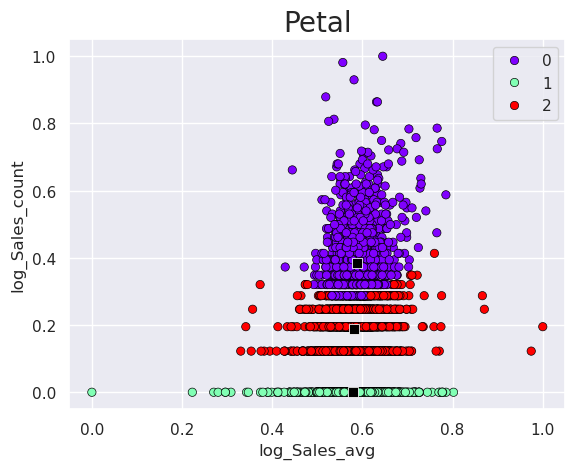

In [41]:
gmm_pipe = Pipeline([
    ('LogScaler', make_column_transformer((LogScaler, data.columns), remainder='passthrough')),
    ('MinMaxScaler', MinMaxScaler()),
    ('GMM', GaussianMixture(n_components = 3, random_state=1))
])
gmm_pipe.fit(data)
labels = gmm_pipe.fit_predict(data)

data_scaled_group = (
    pd.DataFrame(gmm_pipe[:-1].transform(data), columns = ['log_Sales_avg', 'log_Sales_count'])
    .assign(Group = labels)
)

means = gmm_pipe.named_steps['GMM'].means_

print(data_scaled_group)
print()

sbn.set_theme(style='darkgrid')
sbn.scatterplot(data = data_scaled_group, x = 'log_Sales_avg', y = 'log_Sales_count', hue = 'Group', palette = 'rainbow', edgecolors = 'black')
sbn.scatterplot(x = means[:,0], y = means[:,1], color = 'black', marker = 's', s = 50)
plt.title('Petal', size = 20)

plt.show()